In [1]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # has not effect

import sys
sys.path.append("../")
device="cuda"
from tqdm import tqdm_notebook as tqdm

from gaussian_renderer import render, network_gui
from arguments import ModelParams, PipelineParams, OptimizationParams
import argparse
from scene import Scene, GaussianModel
from random import randint
from argparse import ArgumentParser, Namespace

saving_steps = [1, 100, 300, 1_000, 3_000, 7_000, 10_000, 15_000, 20_000, 30_000]
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--save_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=saving_steps)# default=[])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(("-s /home/dimakot55/data/nerf_synthetic/hotdog/ "+\
                         "--model_path /home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2_test_notebook14/").split())#sys.argv[1:])
#args.save_iterations.append(args.iterations)
dataset=lp.extract(args)
pipe=pp.extract(args)
opt=op.extract(args)
os.makedirs(args.model_path, exist_ok=True)

In [2]:

# Functions from @Mateen Ulhaq and @karlo for visualizing 3d points with equal scaling of axes
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])



# Load content scene

In [547]:
os.makedirs(args.model_path, exist_ok=True)
content_gaussians = GaussianModel(3)
content_scene = Scene(dataset, content_gaussians, shuffle=False)
content_gaussians.training_setup(opt)

Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [4]:
! ls /home/dimakot55/output_data/content_scenes_fitted/

GT_chair  GT_drums  GT_ficus  GT_hotdog  GT_lego  GT_materials	GT_mic	GT_ship


In [894]:
content_gaussians.restore(torch.load("/home/dimakot55/output_data/content_scenes_fitted/GT_hotdog/chkpnt30000.pth")[0], opt)


In [895]:

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)
viewpoint_stack = content_scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
#viewpoint_cam = viewpoint_stack.pop(4) # 6, 2, 4, 5, 7


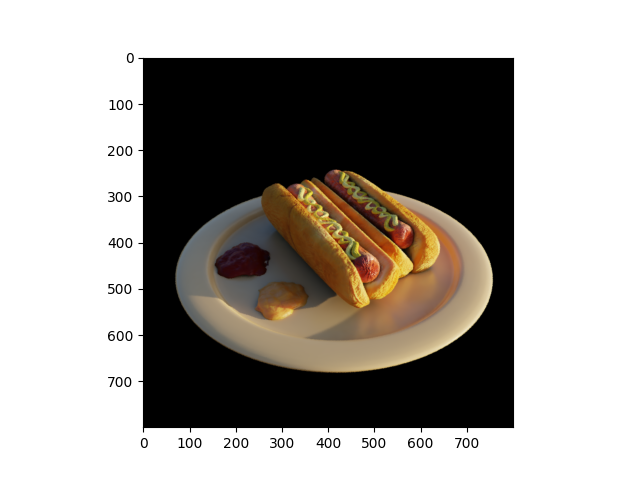

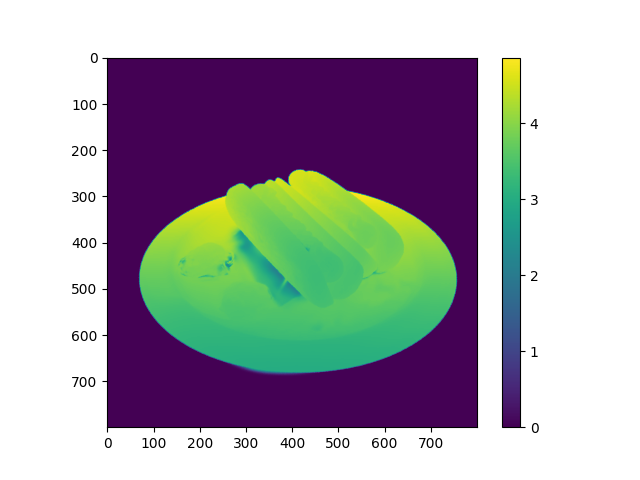

In [896]:

render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth_cont.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


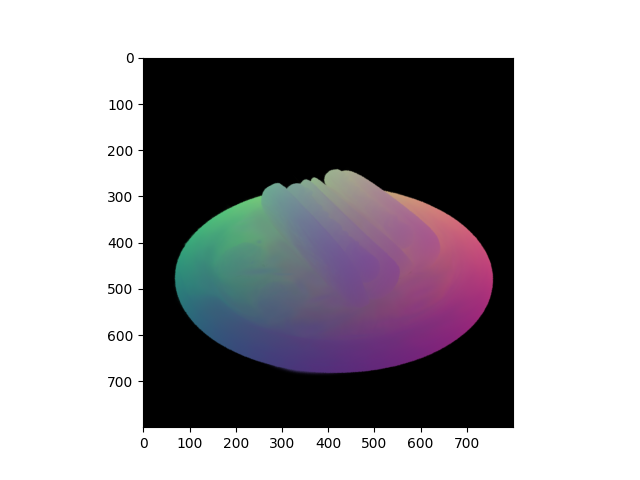

In [897]:
content_gaussians._opacity.data +=  1e6
content_gaussians_features_ds_original = content_gaussians._features_dc.detach().clone()
content_gaussians._features_dc.data = content_gaussians._xyz.data.clone().detach().unsqueeze(1)
content_gaussians._features_rest.data = content_gaussians._features_rest.data * 0.



render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()

# Load style cluster

In [552]:
def load_cluster(path_to_cluster="/home/dimakot55/output_data/gs_my/GT_rose_bush_spheres_clusters_30/cluster_15.npz",
                 preprocess_points=True):
    loaded_data = np.load(path_to_cluster)
    # Access the arrays by their names
    gaussians_xyz = loaded_data['_xyz']
    gaussians_features_dc = loaded_data['_features_dc']
    gaussians_features_rest = loaded_data['_features_rest']
    gaussians_rotation = loaded_data['_rotation']
    gaussians_scaling = loaded_data['_scaling']
    gaussians_opacity = loaded_data['_opacity']

    if not preprocess_points:
        return {"_xyz" : gaussians_xyz,
        "_features_dc" : gaussians_features_dc,
        "_features_rest" : gaussians_features_rest,
        "_rotation" : gaussians_rotation,
        "_scaling" : gaussians_scaling,
        "_opacity" : gaussians_opacity}
    
    # 1. Remove poitns that are too far away from all other points. These are just noise
    # Compute all pairwise distances between points
    from scipy.spatial import distance
    k=10
    pairwise_distances = distance.cdist(gaussians_xyz, gaussians_xyz, 'euclidean')
    # Use np.partition to find the k-th smallest distances for each row
    kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
    kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
    q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.925) # was 0.925
    idcs = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
    gaussians_xyz = gaussians_xyz[idcs]
    gaussians_features_dc = gaussians_features_dc[idcs]
    gaussians_features_rest = gaussians_features_rest[idcs]
    gaussians_rotation = gaussians_rotation[idcs]
    gaussians_scaling = gaussians_scaling[idcs]
    gaussians_opacity = gaussians_opacity[idcs]
    
    
    return {"_xyz" : gaussians_xyz,
        "_features_dc" : gaussians_features_dc,
        "_features_rest" : gaussians_features_rest,
        "_rotation" : gaussians_rotation,
        "_scaling" : gaussians_scaling,
        "_opacity" : gaussians_opacity}
            

In [10]:

# cluster_rose_bush = load_cluster(os.path.join("/home/dimakot55/output_data/gs_my/GT_anthurium_spheres_clusters_5/", "cluster_0.npz"))
cluster1 = load_cluster("/home/dimakot55/output_data/style_clusters/GT_pebbles_spheres_10_clusters/cluster_1.npz")
print(cluster1["_xyz"].shape)

(12553, 3)


In [14]:
gaussians_opt = GaussianModel(3)#.to(device="cuda")
scene_opt = Scene(dataset, gaussians_opt, shuffle=True)


gaussians_opt._xyz.data = torch.tensor(cluster1["_xyz"]).to(device=device)
gaussians_opt._features_dc.data = torch.tensor(cluster1["_features_dc"]).to(device=device)
gaussians_opt._features_rest.data = torch.tensor(cluster1["_features_rest"]).to(device=device)
gaussians_opt._rotation.data = torch.tensor(cluster1["_rotation"]).to(device=device)
gaussians_opt._scaling.data = torch.tensor(cluster1["_scaling"]).to(device=device)
gaussians_opt._opacity.data = torch.tensor(cluster1["_opacity"]).to(device=device)

N = len(gaussians_opt._features_dc.data)
gaussians_opt.max_radii2D.data = torch.concat([torch.tensor(content_gaussians.max_radii2D[:1])]*N).to(device=device)
gaussians_opt.xyz_gradient_accum.data = torch.concat([torch.tensor(content_gaussians.xyz_gradient_accum[:1])]*N).to(device=device)
gaussians_opt.denom.data = torch.concat([torch.tensor(content_gaussians.denom[:1])]*N).to(device=device)


Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


/tmp/ipykernel_4131744/230508808.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.max_radii2D.data = torch.concat([torch.tensor(content_gaussians.max_radii2D[:1])]*N).to(device=device)
/tmp/ipykernel_4131744/230508808.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.xyz_gradient_accum.data = torch.concat([torch.tensor(content_gaussians.xyz_gradient_accum[:1])]*N).to(device=device)
/tmp/ipykernel_4131744/230508808.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.denom.data = torch.conca

In [15]:

with torch.no_grad():
    gaussians_opt._features_dc.data = gaussians_opt._xyz.data.clone().detach().unsqueeze(1)
    gaussians_opt._features_rest.data = gaussians_opt._features_rest.data * 0.

In [16]:
gaussians_opt._features_rest.data = gaussians_opt._features_rest.data * 0.


In [14]:

with torch.no_grad():
    gaussians_opt._xyz.data *= 2



In [15]:
# def sigmoid(x):
#   return 1 / (1 + np.exp(-x))
# def sigmoid_inverse(x):
#     return -np.log(1/x -1.)
# def logit(p):
#     return torch.log(p / (1 - p))

with torch.no_grad():
    gaussians_opt._scaling.data = torch.logit(torch.sigmoid(gaussians_opt._scaling.data) * 2.)
    #sigmoid_inverse(sigmoid(cluster["_scaling"]) * cluster_scaling * SCALING_CONSTANT
    

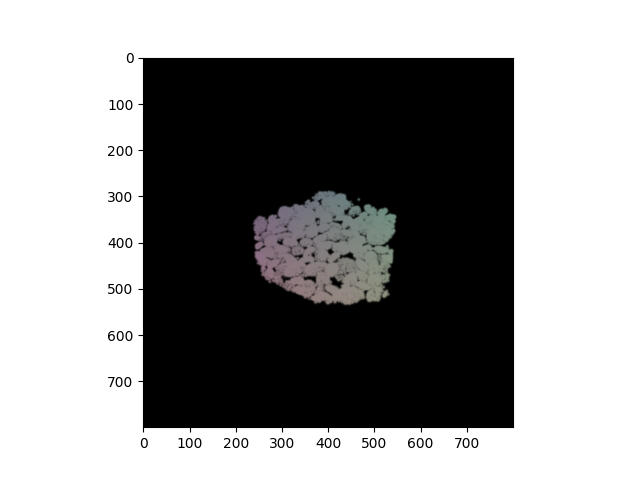

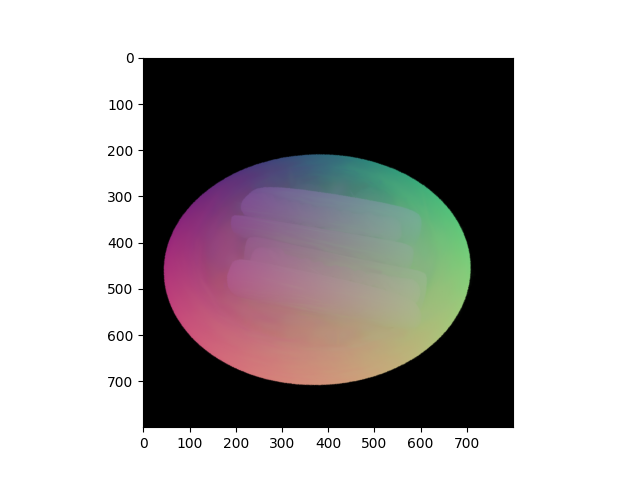

In [16]:
SCALING_FACTOR=1.0 #
# Sample camera
viewpoint_stack = scene_opt.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
gaussians_opt._scaling.data /=  SCALING_FACTOR





# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

gaussians_opt._scaling.data *=  SCALING_FACTOR


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()



In [19]:
gaussians_opt.training_setup(opt)

In [27]:
import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './dummy_scene/' 
# MODEL_DIR_NEW = './fit_hotdog_with_rose_bush_lego_coast_rocks_fitted_with_masks_orig_scaling/'
MODEL_DIR_NEW = './cluster_pebbles_init_only_features_dc_upscaledX2/'
os.makedirs(MODEL_DIR_NEW, exist_ok = True)

! cp -r {MODEL_DIR}* {MODEL_DIR_NEW}
# ls MODEL_DIR


iteration=1
torch.save((gaussians_opt.capture(), iteration), MODEL_DIR_NEW + "/chkpnt" + str(iteration) + ".pth")
gaussians_opt.save_ply(os.path.join(MODEL_DIR_NEW, "point_cloud/iteration_1/", "point_cloud.ply"))



## Change points location and adjust scaling accordingly

In [11]:
with torch.no_grad():
    gaussians_opt._xyz.data = torch.tensor(cluster1["_xyz"]*2).to(device=device)
    gaussians_opt._scaling.data = torch.tensor(cluster1["_scaling"]).to(device=device)
    gaussians_opt._scaling.data = torch.logit(torch.sigmoid(gaussians_opt._scaling.data)*2.)

NameError: name 'gaussians_opt' is not defined

In [218]:

def get_descriptors(X, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        distances_nns : tensor of shape [N, k,k] with pairwise distances between all of the 
            k NNs for every sample in X.
    """

    #print("X.shape:", X.shape)
    #print("X_nns_indices:", X_nns_indices)
    X_nns = X[X_nns_indices]
    # All pairs can be too much
    # distances_nns = torch.norm(X_nns.unsqueeze(1) - X_nns.unsqueeze(2), dim=-1)
    # Just take all distances to the nearest neighbors
    distances_nns = torch.norm(X_nns[:,1:] - X_nns[:,0].unsqueeze(1), dim=-1)
    return distances_nns
    
num_nns = 50
kth_nn = 2


distances = torch.cdist(gaussians_opt._xyz.data, 
                            gaussians_opt._xyz.data)
_, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)
nns_indices = nns_indices[:, ::kth_nn]
target_descriptor_cluster = get_descriptors(X=gaussians_opt._xyz.data, 
                                            X_nns_indices=nns_indices)

target_descriptor_cluster = target_descriptor_cluster.clone().detach()

In [219]:
target_descriptor_cluster

tensor([[0.0122, 0.0144, 0.0202,  ..., 0.0498, 0.0502, 0.0510],
        [0.0172, 0.0189, 0.0250,  ..., 0.0510, 0.0518, 0.0526],
        [0.0114, 0.0130, 0.0142,  ..., 0.0424, 0.0433, 0.0435],
        ...,
        [0.0128, 0.0156, 0.0190,  ..., 0.0417, 0.0440, 0.0457],
        [0.0022, 0.0025, 0.0092,  ..., 0.0539, 0.0552, 0.0562],
        [0.0039, 0.0115, 0.0137,  ..., 0.0439, 0.0441, 0.0445]],
       device='cuda:0')

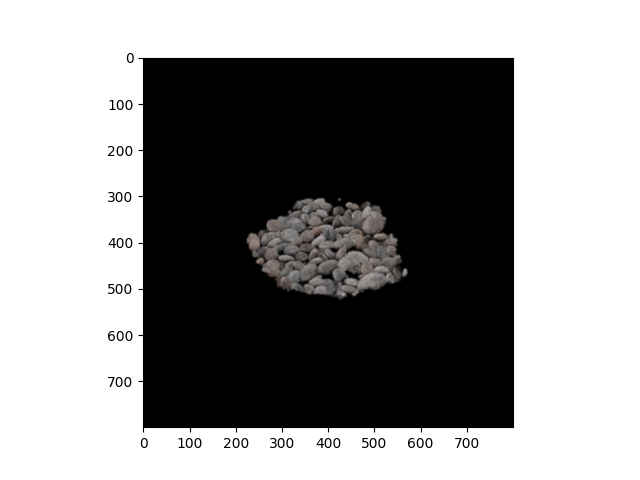

In [220]:
# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


In [221]:
with torch.no_grad():
    gaussians_opt._xyz.data *= (1.+1.*torch.linalg.norm(gaussians_opt._xyz.data,dim=-1).unsqueeze(1))
    gaussians_opt._xyz.data[:,1] += (torch.linalg.norm(gaussians_opt._xyz.data,dim=-1)/1. - 1.)

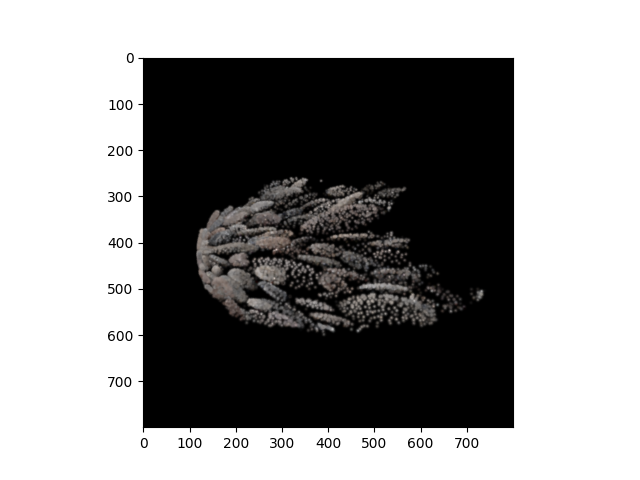

In [222]:
# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


In [223]:
descriptor_cluster_new = get_descriptors(X=gaussians_opt._xyz.data, 
                                            X_nns_indices=nns_indices)
descriptor_cluster_new.shape

torch.Size([12553, 24])

In [224]:

scalings = torch.mean((descriptor_cluster_new / target_descriptor_cluster), dim=-1).unsqueeze(-1)
gaussians_opt._scaling.data = torch.logit(torch.sigmoid(gaussians_opt._scaling.data)*scalings)

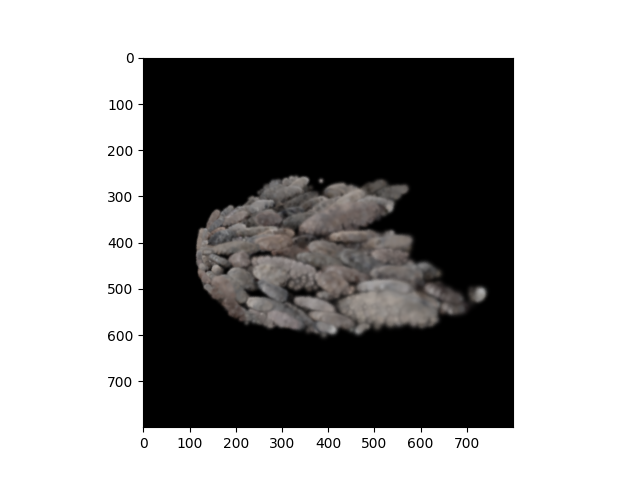

In [216]:
# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


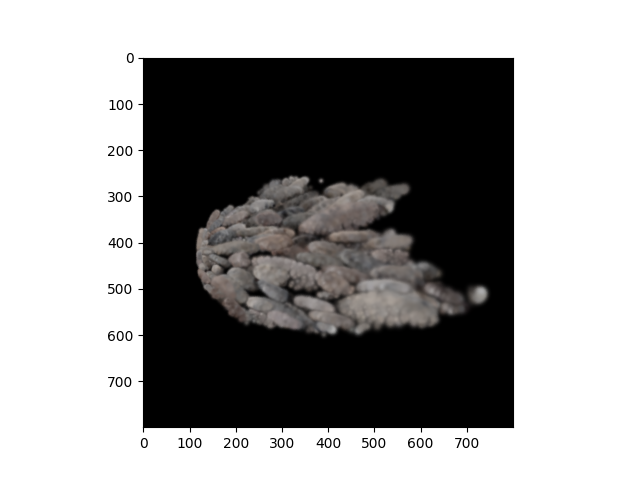

In [225]:
# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


In [147]:
scalings = torch.mean((descriptor_cluster_new / target_descriptor_cluster))
gaussians_opt._scaling.data = torch.logit(torch.sigmoid(gaussians_opt._scaling.data)*scalings)

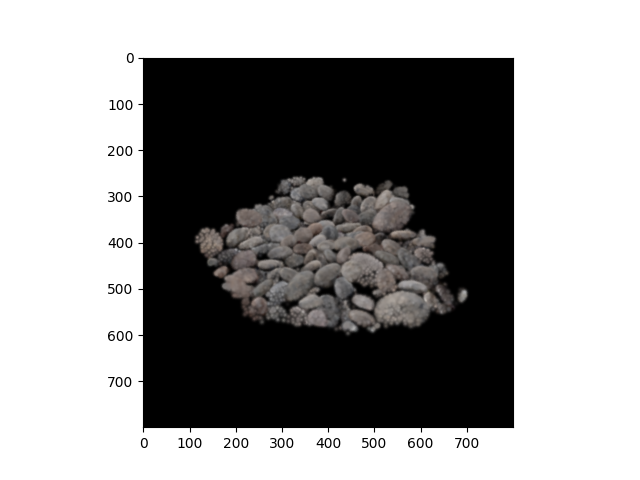

In [148]:
# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


In [ ]:
# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


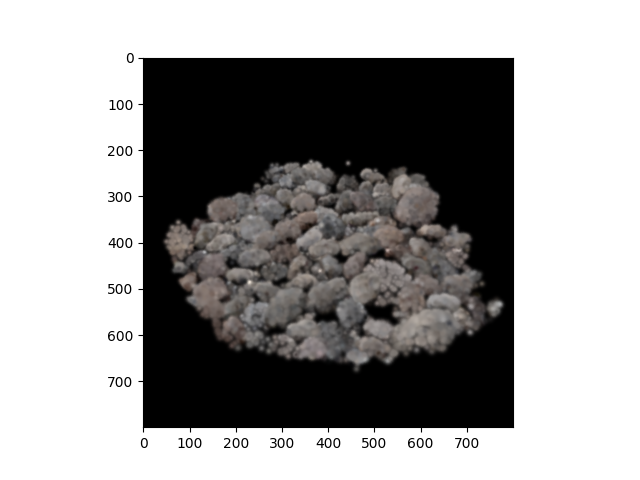

In [66]:
with torch.no_grad():
    noise_xyz = torch.normal(mean=0., std=0.01, size=gaussians_opt._xyz.shape).to("cuda")
    gaussians_opt._xyz.data += noise_xyz
    
# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


# Optimize for the hotdog shape with the new loss on descriptors and good initialization.

In [11]:
## Initialization using clustering

In [12]:

sys.path.append("../")
from utils import sh_utils

In [898]:

sys.path.append("../")
from utils import sh_utils
def obtain_surface_pc(viewpoint_stack, gaussians, pipe, background, num_viewpoints=40, pc_size=20000):
    import numpy as np
    import skimage.measure, skimage.morphology
    import scipy

    # 1. Render from different viewpoints and extract points
    all_points = []
    for iter in range(min(num_viewpoints, len(viewpoint_stack))):
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        render_pkg_cont = render(viewpoint_cam, gaussians, pipe, background)
        image = render_pkg_cont["render"]
        image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
        image_maxpool = skimage.measure.block_reduce(image_rgb, (3,3,1), np.max)
        mask = scipy.ndimage.binary_erosion(np.max(image_maxpool, axis=-1) > 0.05, structure=None, iterations=3)
        image_clean = image_maxpool * np.expand_dims(mask, axis=-1)
        all_points += list(image_clean[np.min(image_clean, axis=-1)>0.05])
    
    
    # 2. Subsample the points 
    all_points = np.array(all_points)
    all_points_idcs = np.random.choice(range(len(all_points)), size=pc_size, replace=False) 
    all_points = all_points[all_points_idcs]

    # 3. Remove poitns that are too far away from all other points.
    # Compute all pairwise distances between points
    from scipy.spatial import distance
    k=10
    pairwise_distances = distance.cdist(all_points, all_points, 'euclidean')
    # Use np.partition to find the k-th smallest distances for each row
    kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
    kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
    q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.95)
    idcs = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
    all_points = all_points[idcs]
    return all_points
    
content_surface_pc = obtain_surface_pc(viewpoint_stack=viewpoint_stack, 
                               gaussians=content_gaussians, 
                               pipe=pipe, 
                               background=background,
                               num_viewpoints=40)

content_surface_pc = sh_utils.RGB2SH(content_surface_pc)

In [899]:
content_surface_pc

array([[-0.04171599,  0.081681  ,  0.26152638],
       [-0.00949107, -0.6745141 ,  0.2278429 ],
       [-0.7389469 , -0.54700595, -0.11679852],
       ...,
       [-0.833023  , -0.92878056, -0.07404571],
       [-1.06374   , -0.19201078, -0.05721961],
       [-0.27155203, -0.2029847 ,  0.0833762 ]], dtype=float32)

In [900]:
content_surface_pc.shape, content_gaussians._xyz.data.shape

((19000, 3), torch.Size([167346, 3]))

In [901]:
content_surface_pc.shape, content_gaussians._xyz.data.shape

((19000, 3), torch.Size([167346, 3]))

In [902]:
content_shape_cluster_centers = []
content_shape_cluster_scalings = []



from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=50)
kmeans.fit(content_surface_pc)

# Centers gonna be kmeans cluster_centers
style_clusters_centers = kmeans.cluster_centers_


/home/dimakot55/miniconda3/envs/gs/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


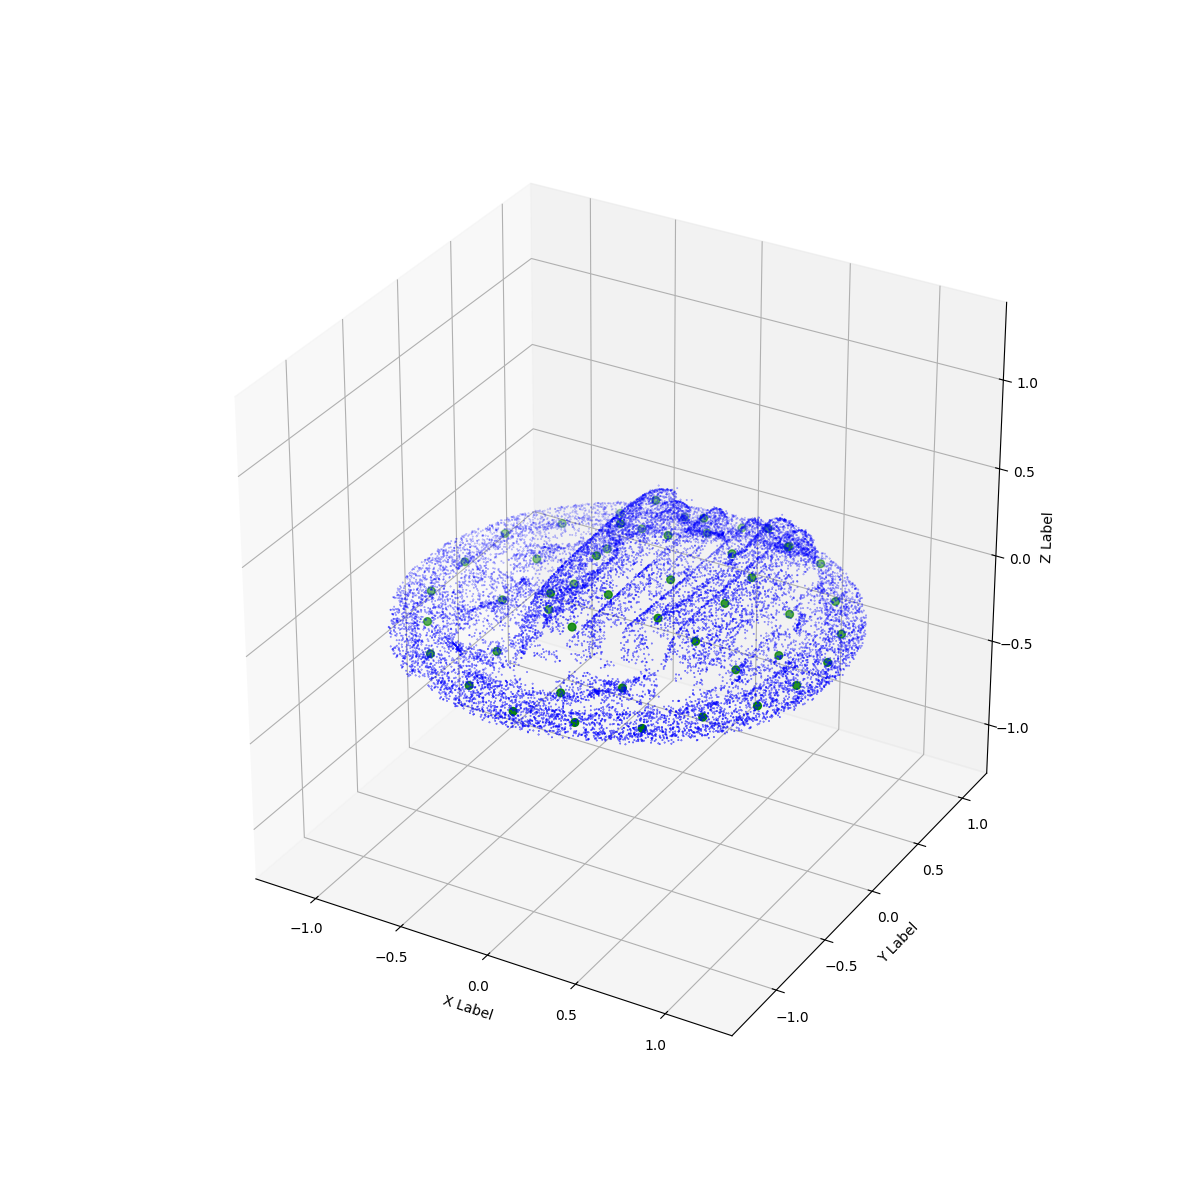

In [903]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    ax.scatter(content_surface_pc[::kth,0], 
               content_surface_pc[::kth,1], 
               content_surface_pc[::kth,2], c='b', marker='o',s=0.1)


kth=10
if False:
    #arr = results[0]["masks_points"][15]
    #arr = normalize_points_according_to_target_distr(results[0]["masks_points"][key])
    arr = content_gaussians._xyz.data.detach().cpu().numpy()
    ax.scatter(arr[::kth,0], 
               arr[::kth,1], 
               arr[::kth,2], c='r', marker='o',s=0.5)


kth=1
if True:
    #arr = results[0]["masks_points"][15]
    arr = style_clusters_centers
    ax.scatter(arr[::kth,0], 
               arr[::kth,1], 
               arr[::kth,2], c='g', marker='o',s=30.5)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

In [904]:
cluster1["_xyz"].shape

(12553, 3)

In [905]:

# Now find optimal scalings
# First find the diameter of the style cluster
# only take every 10th point to accelerate computation of large clusters
cluster_points = torch.tensor(cluster1["_xyz"][::10]).to("cuda")
cluster_distances = torch.cdist(cluster_points, cluster_points)
style_cluster_diameter = torch.max(cluster_distances)
style_cluster_diameter = float(style_cluster_diameter.detach().cpu().numpy())
print(style_cluster_diameter)

# Now for each k_means.cluster
# get diameters of clusters of the kmeans clustering

# Initialize maximum diameter variable for each cluster

max_diameters = np.zeros(kmeans.n_clusters)

# Calculate diameter (max distance) for each cluster
for cluster in range(kmeans.n_clusters):
    # Extract points belonging to the current cluster
    cluster_points = content_surface_pc[kmeans.labels_ == cluster]

    # Calculate pairwise distances within the cluster
    if len(cluster_points) > 1:
        cluster_points = torch.tensor(cluster_points).to("cuda")
        distances = torch.cdist(cluster_points, cluster_points)
        max_diameters[cluster] = float(torch.max(distances).detach().cpu().numpy())

print("Maximum diameters for each cluster:", max_diameters)
print("\n\n")

style_clusters_scalings = max_diameters/style_cluster_diameter * 1.25


0.6180887818336487
Maximum diameters for each cluster: [0.36057842 0.42070487 0.44952959 0.37410197 0.32193542 0.45444703
 0.40105319 0.38799039 0.39110512 0.38082036 0.36411482 0.34754378
 0.35802755 0.43910128 0.44764873 0.45023319 0.43557179 0.43741074
 0.39187744 0.38155484 0.38818252 0.44253063 0.38213319 0.3845343
 0.36640099 0.38721707 0.40894893 0.45437843 0.44090593 0.38265452
 0.37849388 0.39072996 0.3599737  0.40740198 0.37249264 0.44578481
 0.37512577 0.48819438 0.37617087 0.399178   0.47017029 0.36780456
 0.39662972 0.41913813 0.36948124 0.3673313  0.40475622 0.37623686
 0.38806733 0.33923769]





In [906]:
style_clusters_centers, style_clusters_scalings 

(array([[ 0.36847514,  0.70543003,  0.1574787 ],
        [ 0.08185187, -0.8616077 , -0.07413983],
        [-0.6935905 ,  0.20897338, -0.07581686],
        [ 0.5916579 , -0.43767628,  0.14919378],
        [ 1.074416  ,  0.02400362, -0.06437863],
        [-0.8466677 , -0.591943  , -0.08241539],
        [ 0.21574672, -0.0208023 ,  0.17789824],
        [ 0.5973686 , -0.9659369 , -0.06296524],
        [-0.5586974 ,  0.82125044, -0.06787496],
        [-0.21370362,  0.22807914,  0.25385922],
        [ 0.7230243 ,  0.28189716, -0.02402583],
        [ 1.046489  , -0.24340212, -0.06452232],
        [-0.18990105,  0.5417198 ,  0.24410169],
        [-0.7690472 ,  0.5894642 , -0.07445467],
        [-0.19283795, -0.4910461 ,  0.2181263 ],
        [-0.99487287,  0.00216302, -0.07603592],
        [-0.66205126, -0.8606528 , -0.07528938],
        [ 0.79084396, -0.71959615, -0.07009958],
        [-0.3611652 ,  0.01653785, -0.03044502],
        [-0.3229834 , -0.2921641 , -0.01183421],
        [ 0.7257027 

In [907]:

def get_descriptors(X, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        distances_nns : tensor of shape [N, k,k] with pairwise distances between all of the 
            k NNs for every sample in X.
    """

    #print("X.shape:", X.shape)
    #print("X_nns_indices:", X_nns_indices)
    X_nns = X[X_nns_indices]
    # All pairs can be too much
    # distances_nns = torch.norm(X_nns.unsqueeze(1) - X_nns.unsqueeze(2), dim=-1)
    # Just take all distances to the nearest neighbors
    distances_nns = torch.norm(X_nns[:,1:] - X_nns[:,0].unsqueeze(1), dim=-1)
    return distances_nns
    
num_nns = 50
kth_nn = 3


STYLE_CLUSTER_SIZE = len(cluster1["_xyz"])

distances = torch.cdist(torch.tensor(cluster1["_xyz"]).to(device=device), 
                        torch.tensor(cluster1["_xyz"]).to(device=device))
_, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)
nns_indices = nns_indices[:, ::kth_nn]
target_descriptor_cluster = get_descriptors(X=torch.tensor(cluster1["_xyz"]).to(device=device), 
                                            X_nns_indices=nns_indices)
target_descriptor_cluster = target_descriptor_cluster.clone().detach()

## Initialize the scene with the clusters.

In [580]:
gaussians_opt = GaussianModel(3)#.to(device="cuda")
scene_opt = Scene(dataset, gaussians_opt, shuffle=True)


Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [908]:
style_clusters = [cluster1]*len(style_clusters_centers)
gaussians_opt._features_dc.data = torch.concat([torch.tensor(x["_features_dc"]).to(device=device) for x in style_clusters])
gaussians_opt._features_rest.data = torch.concat([torch.tensor(x["_features_rest"]).to(device=device) for x in style_clusters])
gaussians_opt._rotation.data = torch.concat([torch.tensor(x["_rotation"]).to(device=device) for x in style_clusters])
gaussians_opt._scaling.data = torch.concat([torch.tensor(x["_scaling"]).to(device=device) for x in style_clusters])
gaussians_opt._opacity.data = torch.concat([torch.tensor(x["_opacity"]).to(device=device) for x in style_clusters])

N = len(gaussians_opt._features_dc.data)
gaussians_opt.max_radii2D.data = torch.concat([torch.tensor(content_gaussians.max_radii2D[:1])]*N).to(device=device)
gaussians_opt.xyz_gradient_accum.data = torch.concat([torch.tensor(content_gaussians.xyz_gradient_accum[:1])]*N).to(device=device)
gaussians_opt.denom.data = torch.concat([torch.tensor(content_gaussians.denom[:1])]*N).to(device=device)


/tmp/ipykernel_4168896/3583805269.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.max_radii2D.data = torch.concat([torch.tensor(content_gaussians.max_radii2D[:1])]*N).to(device=device)
/tmp/ipykernel_4168896/3583805269.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.xyz_gradient_accum.data = torch.concat([torch.tensor(content_gaussians.xyz_gradient_accum[:1])]*N).to(device=device)
/tmp/ipykernel_4168896/3583805269.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.denom.data = torch.con

In [909]:
style_clusters_indcs = [(i*STYLE_CLUSTER_SIZE, (i+1)*STYLE_CLUSTER_SIZE) for i in range(len(style_clusters))]

In [910]:
gaussians_opt_features_dc_original = gaussians_opt._features_dc.data.detach().clone()
gaussians_opt_features_rest_original = gaussians_opt._features_rest.data.detach().clone()

# No scaling version
# gaussians_opt._xyz.data = torch.concat([torch.tensor( (cluster["_xyz"] - np.mean(cluster["_xyz"], axis=0))*1. + cluster_center).to(device=device) 
#                                           for cluster, cluster_center in zip(style_clusters, content_shape_cluster_centers)])
SCALING_CONSTANT = 1.0
# Determine position of every gaussian. Adjust for cluster center and scaling
gaussians_opt._xyz.data = torch.concat(
    [torch.tensor( (cluster["_xyz"] - np.mean(cluster["_xyz"], axis=0))*cluster_scaling*SCALING_CONSTANT + cluster_center).to(device=device) 
     for cluster, cluster_center, cluster_scaling in zip(style_clusters, style_clusters_centers, style_clusters_scalings)])
# Scale every scaling parameter accordingly
# gaussians_opt._scaling.data = torch.concat(
#     [torch.logit(torch.sigmoid(torch.tensor(cluster["_scaling"]).to(device=device)) * cluster_scaling * SCALING_CONSTANT)
#      for cluster, cluster_scaling in zip(style_clusters, style_clusters_scalings)])


In [911]:
# cluster1["_scaling"] = torch.logit(torch.sigmoid(torch.tensor(cluster1["_scaling"]))*1.3).detach().cpu().numpy()

In [912]:
gaussians_opt._scaling.data = torch.concat([torch.tensor(cluster1["_scaling"]).to(device=device)]* len(style_clusters), dim=0)


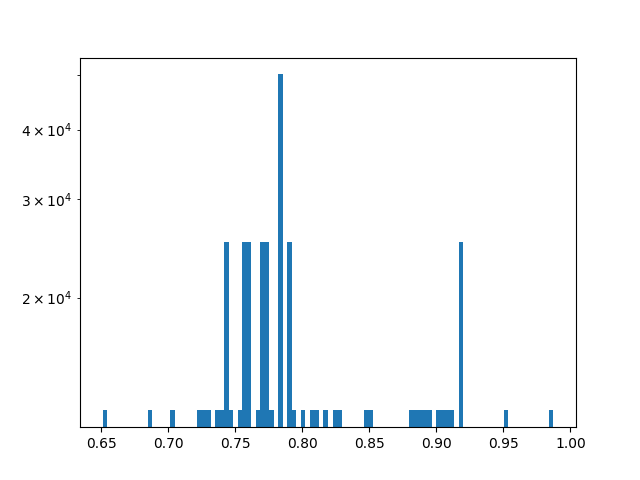

In [913]:
gaussians_opt._scaling.data = torch.concat([torch.tensor(cluster1["_scaling"]).to(device=device)]* len(style_clusters), dim=0)
scalings_current = [get_descriptors(X=gaussians_opt._xyz.data[N_start:N_end], 
                                    X_nns_indices=nns_indices) for (N_start, N_end) in style_clusters_indcs]
scalings = torch.concat([torch.mean(scaling_current,dim=-1) / (1e-8+torch.mean(target_descriptor_cluster,dim=-1))
                         for scaling_current in scalings_current], dim=0)
scalings = scalings.unsqueeze(1)
plt.figure()
plt.hist(scalings.detach().cpu().numpy(), bins=100)
plt.yscale('log')
plt.show()
scalings = torch.clip(scalings, 0.02, 3.)
    
gaussians_opt._scaling.data = torch.logit(torch.sigmoid(gaussians_opt._scaling.data) * scalings)



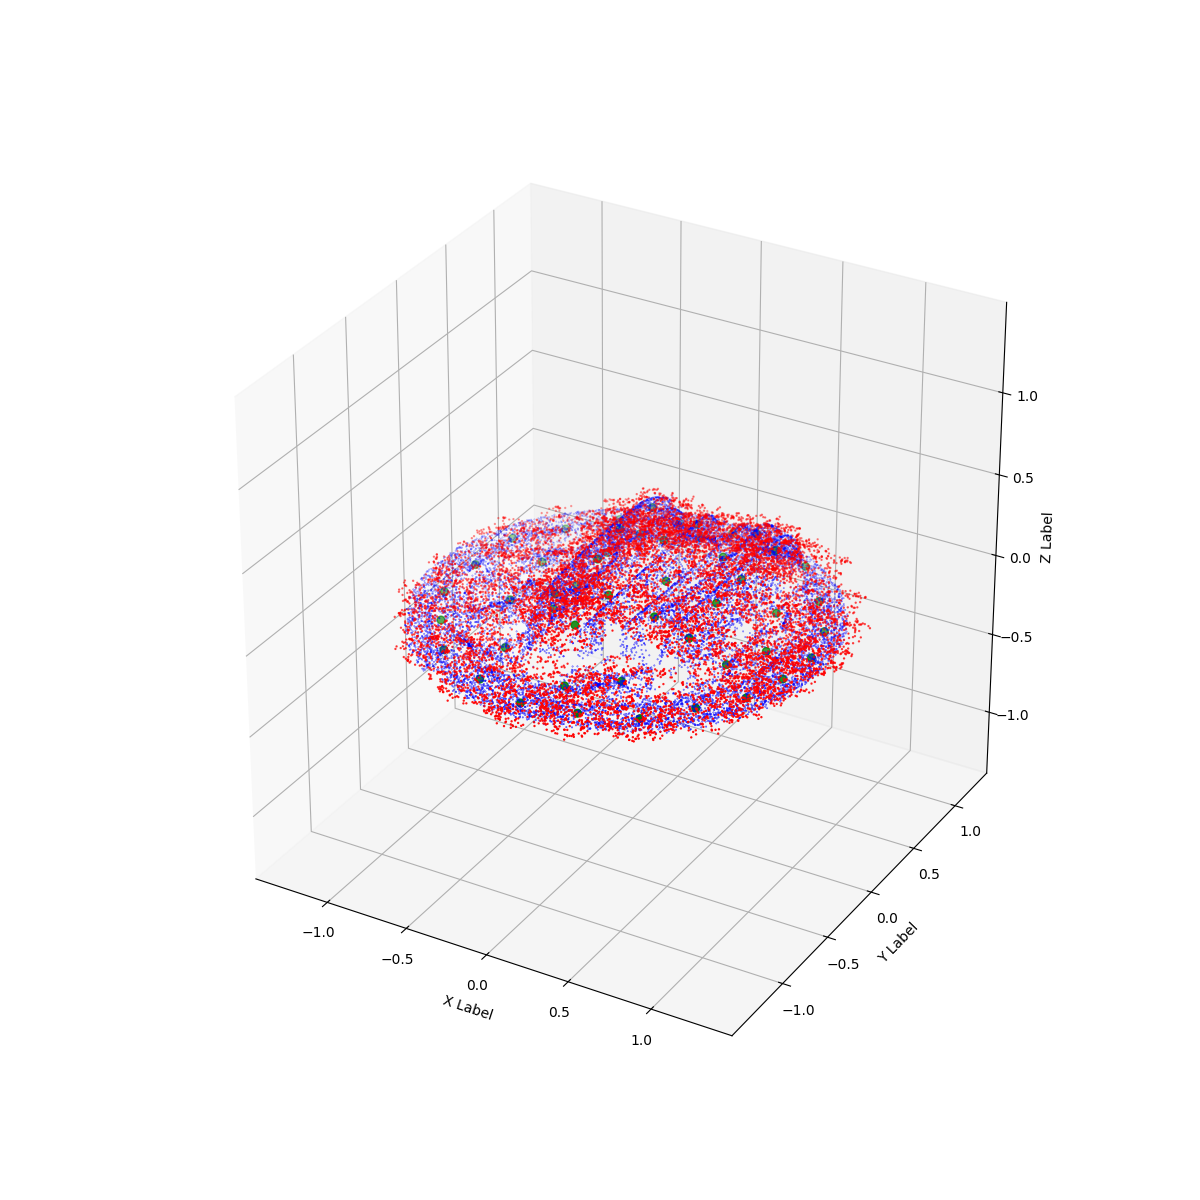

In [914]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    ax.scatter(content_surface_pc[::kth,0], 
               content_surface_pc[::kth,1], 
               content_surface_pc[::kth,2], c='b', marker='o',s=0.1)


kth=50
if True:
    #arr = results[0]["masks_points"][15]
    #arr = normalize_points_according_to_target_distr(results[0]["masks_points"][key])
    arr = gaussians_opt._xyz.data.detach().cpu().numpy()
    ax.scatter(arr[::kth,0], 
               arr[::kth,1], 
               arr[::kth,2], c='r', marker='o',s=0.5)


kth=1
if True:
    #arr = results[0]["masks_points"][15]
    arr = style_clusters_centers
    ax.scatter(arr[::kth,0], 
               arr[::kth,1], 
               arr[::kth,2], c='g', marker='o',s=30.5)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

In [915]:
#Find gaussians close enough to the shape
gaussians_opt_dist_to_content = []
with torch.no_grad():
    BATCH_SIZE = 10_000
    for idx_start in np.arange(0, gaussians_opt._xyz.data.shape[0], BATCH_SIZE):
        idx_end = idx_start+BATCH_SIZE
        #print(idx_start, idx_end)

        batch_opt_to_cont_distances = torch.cdist(gaussians_opt._xyz.data[idx_start:idx_end], content_gaussians._xyz.data[::10])
        batch_opt_to_cont_distances_min = torch.min(batch_opt_to_cont_distances,dim=1)[0]
        gaussians_opt_dist_to_content.append(batch_opt_to_cont_distances_min)
    
gaussians_opt_dist_to_content = torch.concat(gaussians_opt_dist_to_content, dim=0)
MARGIN = 0.03
close_gaussians_opt_idcs = torch.where(gaussians_opt_dist_to_content<MARGIN)[0]
far_gaussians_opt_idcs = torch.where(gaussians_opt_dist_to_content>MARGIN)[0]

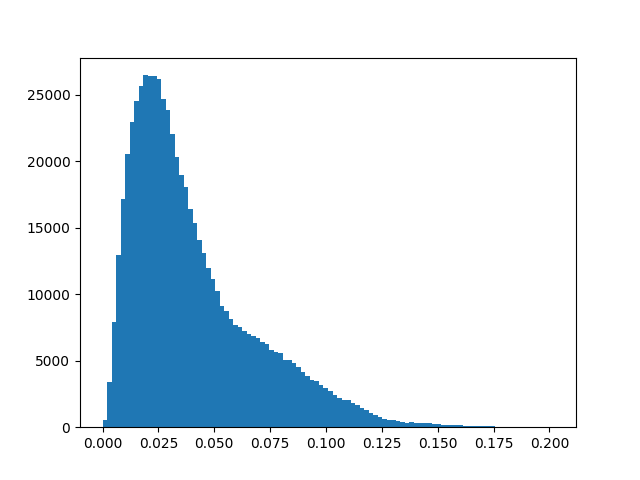

In [916]:
plt.figure()
plt.hist(gaussians_opt_dist_to_content.detach().cpu().numpy(), bins=100)
plt.show()

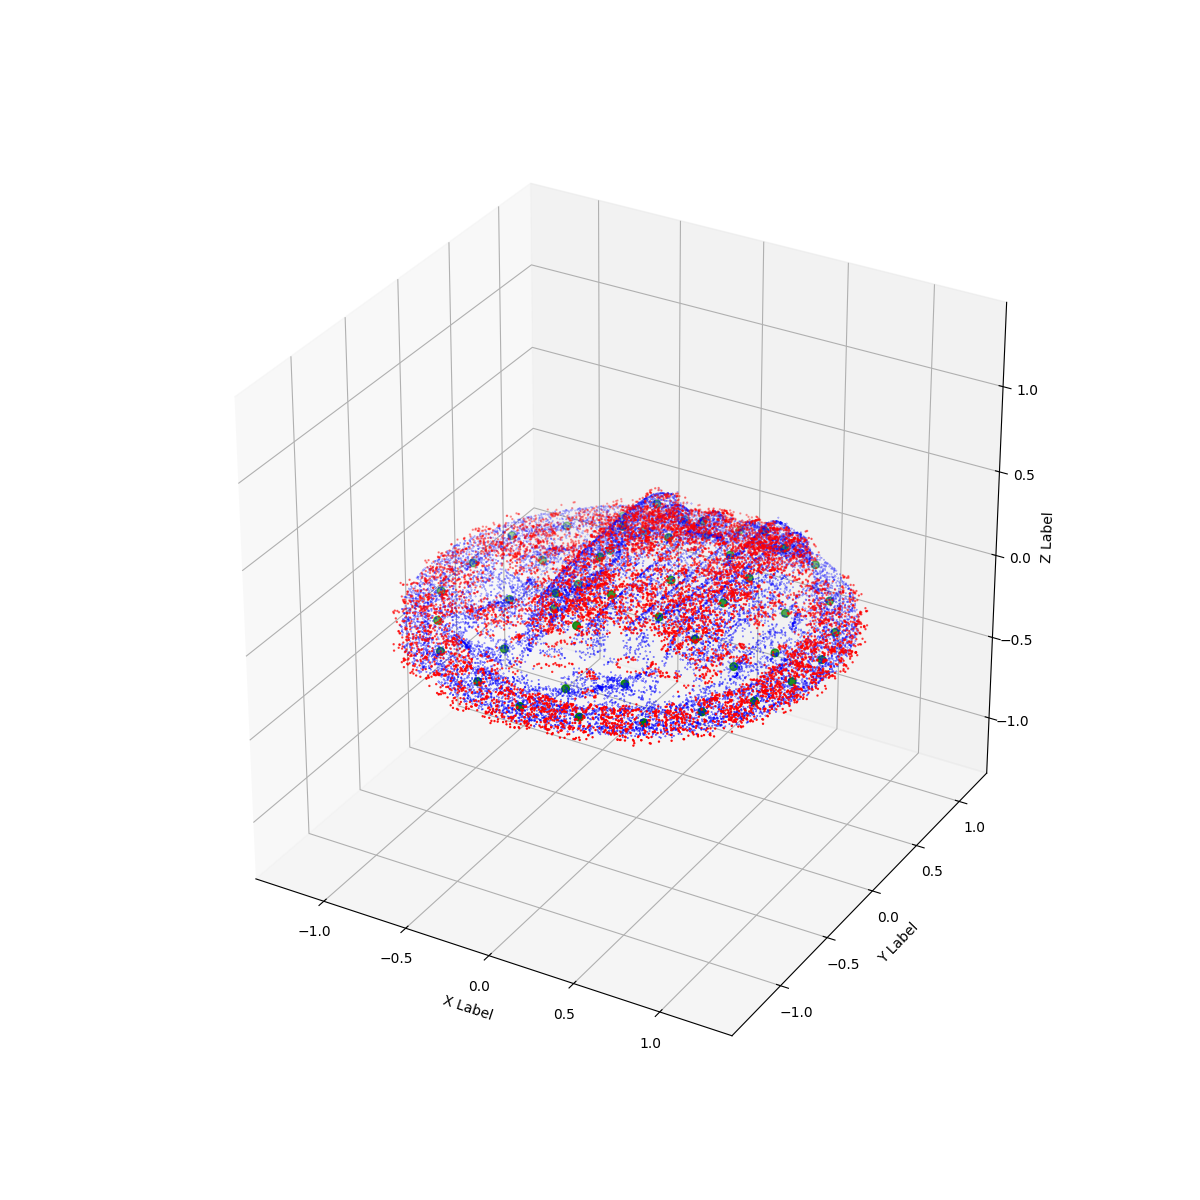

In [917]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    ax.scatter(content_surface_pc[::kth,0], 
               content_surface_pc[::kth,1], 
               content_surface_pc[::kth,2], c='b', marker='o',s=0.1)


kth=50
if True:
    #arr = results[0]["masks_points"][15]
    #arr = normalize_points_according_to_target_distr(results[0]["masks_points"][key])
    close_gaussians_opt_idcs = torch.where(gaussians_opt_dist_to_content<0.05)[0]
    arr = gaussians_opt._xyz.data[close_gaussians_opt_idcs].detach().cpu().numpy()
    ax.scatter(arr[::kth,0], 
               arr[::kth,1], 
               arr[::kth,2], c='r', marker='o',s=0.5)


kth=1
if True:
    #arr = results[0]["masks_points"][15]
    arr = style_clusters_centers
    ax.scatter(arr[::kth,0], 
               arr[::kth,1], 
               arr[::kth,2], c='g', marker='o',s=30.5)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

In [859]:
# # code for rescaling of every point
# style_cluster_scalings = torch.concat([torch.tensor(cluster1["_scaling"]).to(device=device)]*len(style_clusters))

# style_cluster_knns_mean_dist = None

# num_nns = 10
# kth_nn = 1


# STYLE_CLUSTER_SIZE = len(cluster1["_xyz"])

# distances = torch.cdist(torch.tensor(cluster1["_xyz"]).to(device=device), 
#                         torch.tensor(cluster1["_xyz"]).to(device=device))
# nns_vals, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)
# nns_vals = nns_vals[:, ::kth_nn]




In [918]:

with torch.no_grad():
    gaussians_opt._features_dc.data = gaussians_opt._xyz.data.clone().detach().unsqueeze(1)
    gaussians_opt._features_rest.data = gaussians_opt._features_rest.data * 0.

In [919]:
gaussians_opt._opacity.data = torch.concat([torch.tensor(x["_opacity"]).to(device=device) for x in style_clusters])

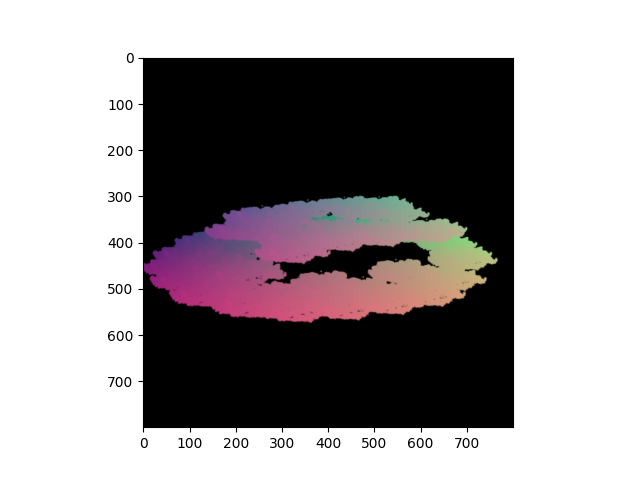

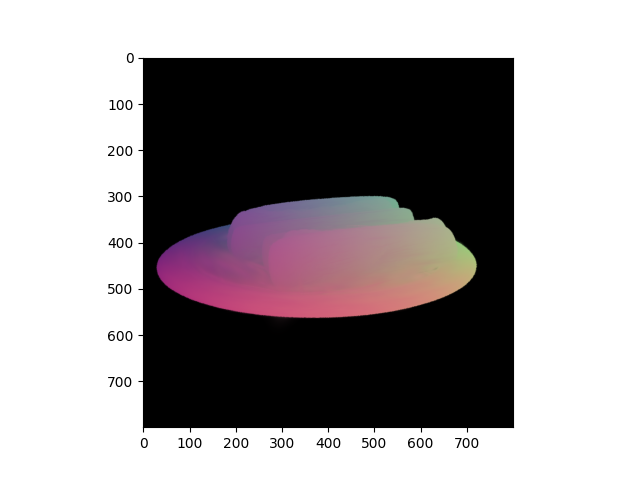

In [920]:
viewpoint_stack = scene_opt.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))





# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()



In [921]:
gaussians_opt._opacity.data = torch.concat([torch.tensor(x["_opacity"]).to(device=device) for x in style_clusters])
with torch.no_grad():
    gaussians_opt._opacity.data[far_gaussians_opt_idcs] = -1e6

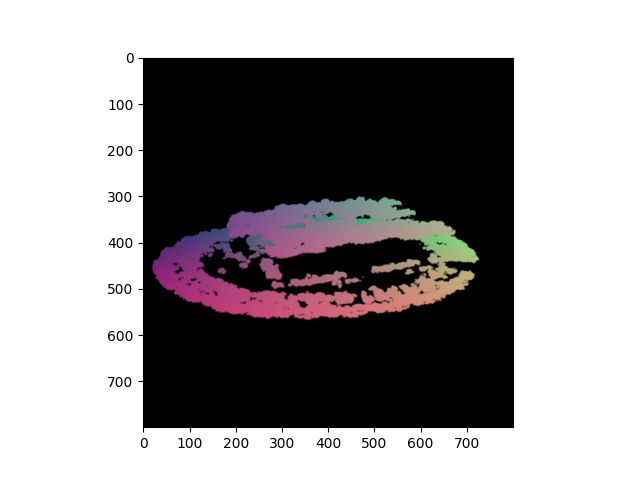

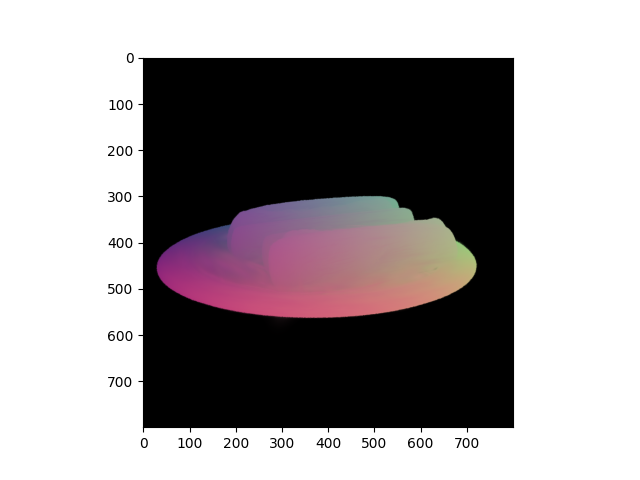

In [922]:




# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()



In [923]:
losses_full=[]
losses_pixel = []
losses_reg = []
losses_tv = []
losses_loc_descr = []
losses_loc_descr_fine = []


gaussians_opt.training_setup(opt)
# for param_group in gaussians_opt.optimizer.param_groups:
#         param_group['lr'] = 1e-4


gaussians_opt._xyz.requires_grad = True
gaussians_opt._features_dc.requires_grad = True
gaussians_opt._features_rest.requires_grad = False
gaussians_opt._scaling.requires_grad = False
gaussians_opt._rotation.requires_grad = False
gaussians_opt._opacity.requires_grad = False
gaussians_opt.max_radii2D.requires_grad = False


In [924]:

def descriptors_loss(descriptors, descriptors_target, normalize=True):
    if not normalize:
        return torch.mean(torch.square(descriptors - descriptors_target))
    else:

        # New version with scaling by the value of the point most further away
        descriptors_scaler = torch.mean(descriptors[:,-1])
        descriptors_target_scaler = torch.mean(descriptors_target[:,-1])

        return torch.mean(torch.square(descriptors/(1e-5+descriptors_scaler) - 
                                       descriptors_target/(1e-5+descriptors_target_scaler)))
        
        
        # Old version with softmax
        # return torch.mean(torch.square(torch.softmax(descriptors*100., dim=-1) - 
        #                                torch.softmax(descriptors_target*100., dim=-1)))
        
        
    
def get_style_patch_descriptors_loss(clusters_to_opt_list, nns_indices, target_descriptor_cluster, normalize=True):
    """
    For every cluster of points in the clusters_to_opt_list we compute its descriptor of spatial 
    positions between all pairs of points within this cluster. Afterwards we compare this descriptor
    with the target descriptor.
    """
    loss_local_descriptor_list = []
    loss = 0.
    if type(nns_indices) is not list:
        for cluster_points in clusters_to_opt_list:
            descriptor_points = get_descriptors(X=cluster_points, X_nns_indices=nns_indices)
            loss_local_descriptor = descriptors_loss(descriptors=descriptor_points,
                                                     descriptors_target=target_descriptor_cluster,
                                                     normalize=normalize)
            loss += loss_local_descriptor 
            loss_local_descriptor_list.append(loss_local_descriptor)
    else:
        for cluster_points, cluster_points_nns_indices, cluster_target_descriptor in \
            zip(clusters_to_opt_list, nns_indices, target_descriptor_cluster):
                #print("cluster_points_nns_indices.shape:", cluster_points_nns_indices.shape)
                descriptor_points = get_descriptors(X=cluster_points, X_nns_indices=cluster_points_nns_indices)
                loss_local_descriptor = loss_local_descriptor = descriptors_loss(descriptors=descriptor_points,
                                                                                 descriptors_target=cluster_target_descriptor,
                                                                                 normalize=normalize)
                loss += loss_local_descriptor 
                loss_local_descriptor_list.append(loss_local_descriptor)
                    

    return loss / len(clusters_to_opt_list)

def calculate_ema(values, alpha=0.01):
    ema = [values[0]]  # Initial value is the same as the first value in the list

    for i in range(1, len(values)):
        ema.append(alpha * values[i] + (1 - alpha) * ema[-1])

    return ema


def l1_loss(network_output, gt):
    return torch.abs((network_output - gt)).mean()


def tv_loss(img):
    return 0.5 * (torch.abs(img[..., 1:, :] - img[..., :-1, :]).mean() +
                  torch.abs(img[..., :, 1:] - img[..., :, :-1]).mean())



In [950]:

for step in tqdm(range(5001)):
    gaussians_opt.optimizer.zero_grad()
    if True:
        # Pick a random Camera
        if not viewpoint_stack:
           viewpoint_stack = scene_opt.getTrainCameras().copy()
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
    # Optimization gaussians
    render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
    image, depth= render_pkg["render"], render_pkg["depth"]
    # Content gaussians
    render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
    image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


    loss_descriptor_local = \
        get_style_patch_descriptors_loss(
            clusters_to_opt_list=[gaussians_opt._xyz[N_start:N_end] / scaling 
                                  for ((N_start, N_end),scaling) in zip(style_clusters_indcs, style_clusters_scalings)],
            nns_indices=nns_indices,
            target_descriptor_cluster=target_descriptor_cluster,
            normalize=False)
   
    loss_pixel = l1_loss(image, image_cont) 
    
    l_tv = tv_loss(image)
    l_reg = torch.mean(torch.square(gaussians_opt._xyz.unsqueeze(1) - gaussians_opt._features_dc))
    
    # loss = loss_pixel * 5e1  + l_tv * 0e-5 + l_reg * 1e1 + loss_descriptor_local * 1e7 #+ loss_descriptor_local_fine * 4e6 # was 1e4
    loss = loss_pixel * 1e1  + l_tv * 0e-5 + l_reg * 1e1 + loss_descriptor_local * 0e0 # First stage 1e2
    loss.backward()

    gaussians_opt.optimizer.step()
    losses_full.append(float(loss.detach().cpu().numpy()))
    losses_pixel.append(float(loss_pixel.detach().cpu().numpy()))
    losses_reg.append(float(l_reg.detach().cpu().numpy()))
    losses_tv.append(float(l_tv.detach().cpu().numpy()))
    losses_loc_descr.append(float(loss_descriptor_local.detach().cpu().numpy()))
    

    with torch.no_grad():
        gaussians_opt._scaling.data = torch.concat([torch.tensor(cluster1["_scaling"]).to(device=device)]* len(style_clusters), dim=0)
        scalings_current = [get_descriptors(X=gaussians_opt._xyz.data[N_start:N_end], 
                                            X_nns_indices=nns_indices) for (N_start, N_end) in style_clusters_indcs]
        #scalings_current = [torch.clip(x, 0.2, 3.) for x in scalings_current]
        scalings = torch.concat([torch.mean(scaling_current,dim=-1) / (1e-8+torch.mean(target_descriptor_cluster,dim=-1))
                                 for scaling_current in scalings_current], dim=0)
        scalings = torch.clip(scalings, 0.02, 3.)
        scalings = scalings.unsqueeze(1)
        gaussians_opt._scaling.data = torch.logit(torch.sigmoid(gaussians_opt._scaling.data) * scalings)
    


    
    if step % 100 == 0:
        print(f"l_reg:{l_reg:.7f}",
              f"loss_descriptor_local:{loss_descriptor_local:.7f}",
              f"l_tv:{l_tv:.7f}, loss_pixel:{loss_pixel:.7f}, loss:{loss:.7f}")
    
  

/tmp/ipykernel_4168896/3984109758.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(5001)):


  0%|          | 0/5001 [00:00<?, ?it/s]

l_reg:0.0001024 loss_descriptor_local:0.0004249 l_tv:0.0011390, loss_pixel:0.0023546, loss:0.0245697
l_reg:0.0000953 loss_descriptor_local:0.0004867 l_tv:0.0014614, loss_pixel:0.0033640, loss:0.0345930
l_reg:0.0000960 loss_descriptor_local:0.0005516 l_tv:0.0010036, loss_pixel:0.0035520, loss:0.0364799
l_reg:0.0000919 loss_descriptor_local:0.0006220 l_tv:0.0012767, loss_pixel:0.0026826, loss:0.0277453
l_reg:0.0000931 loss_descriptor_local:0.0006920 l_tv:0.0014092, loss_pixel:0.0032906, loss:0.0338366


KeyboardInterrupt: 

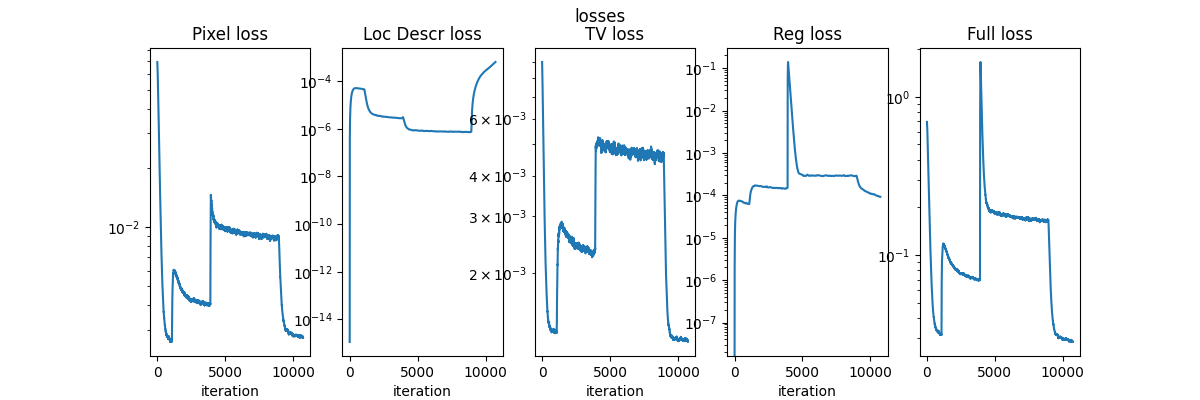

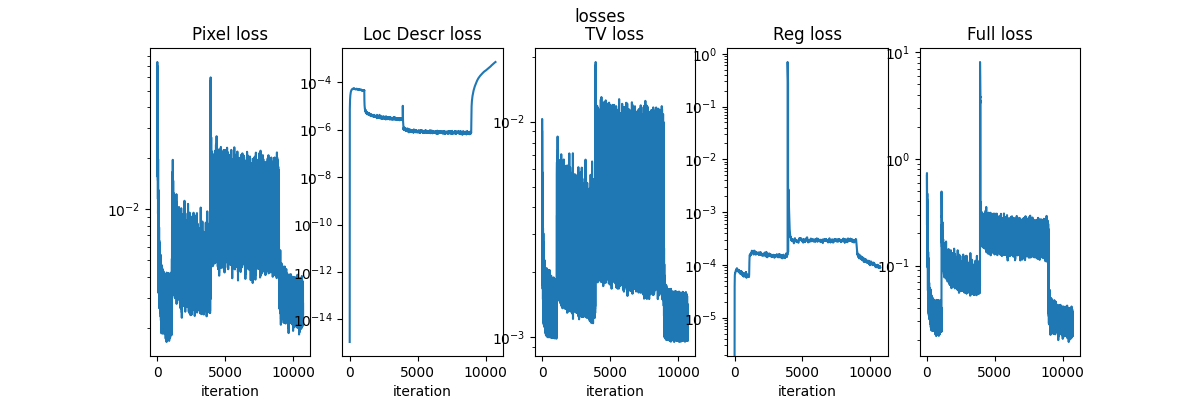

In [951]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
fig.suptitle("losses")
ax[0].set_title("Pixel loss")
ax[0].plot(calculate_ema(losses_pixel))
ax[0].set_yscale('log')
ax[1].set_title("Loc Descr loss")
ax[1].plot(calculate_ema(losses_loc_descr))
ax[1].set_yscale('log')

ax[2].set_title("TV loss")
ax[2].plot(calculate_ema(losses_tv))
ax[2].set_yscale('log')

# ax[2].set_title("Loc Descr fine loss")
# ax[2].plot(calculate_ema(losses_loc_descr_fine))
# ax[2].set_yscale('log')

ax[3].set_title("Reg loss")
ax[3].plot(calculate_ema(losses_reg))
ax[3].set_yscale('log')
ax[4].set_title("Full loss")
ax[4].plot(calculate_ema(losses_full))
ax[4].set_yscale('log')

for i in range(4): ax[i].set_xlabel("iteration")

plt.show()

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
fig.suptitle("losses")
ax[0].set_title("Pixel loss")
ax[0].plot(losses_pixel)
ax[0].set_yscale('log')
ax[1].set_title("Loc Descr loss")
ax[1].plot(losses_loc_descr)
ax[1].set_yscale('log')

ax[2].set_title("TV loss")
ax[2].plot(losses_tv)
ax[2].set_yscale('log')
ax[3].set_title("Reg loss")
ax[3].plot(losses_reg)
ax[3].set_yscale('log')
ax[4].set_title("Full loss")
ax[4].plot(losses_full)
ax[4].set_yscale('log')

for i in range(4): ax[i].set_xlabel("iteration")

plt.show()


In [952]:
gaussians_opt_features_dc_fitted = gaussians_opt._features_dc.data.detach().clone()

In [293]:
gaussians_opt._features_dc.data = gaussians_opt_features_dc_original.clone()
gaussians_opt._features_rest.data = gaussians_opt_features_rest_original.clone()

In [288]:
gaussians_opt._scaling.data = torch.concat([torch.tensor(cluster1["_scaling"]).to(device=device)]* len(style_clusters), dim=0)

In [159]:
with torch.no_grad():
    gaussians_opt._scaling.data = torch.concat([torch.tensor(cluster1["_scaling"]).to(device=device)]* len(style_clusters), dim=0)
    scalings_current = [get_descriptors(X=gaussians_opt._xyz.data[N_start:N_end], 
                                        X_nns_indices=nns_indices) for (N_start, N_end) in style_clusters_indcs]
    #scalings_current = [torch.clip(x, 0.2, 3.) for x in scalings_current]
    scalings = torch.concat([torch.mean(scaling_current,dim=-1) / (1e-8+torch.mean(target_descriptor_cluster,dim=-1))
                             for scaling_current in scalings_current], dim=0)
    scalings = torch.clip(scalings, 0.02, 3.)
    scalings = scalings.unsqueeze(1)
    gaussians_opt._scaling.data = torch.logit(torch.sigmoid(gaussians_opt._scaling.data) * scalings)

In [953]:
scalings = torch.concat([torch.mean(scaling_current,dim=-1) / (1e-8+torch.mean(target_descriptor_cluster,dim=-1))
                             for scaling_current in scalings_current], dim=0)

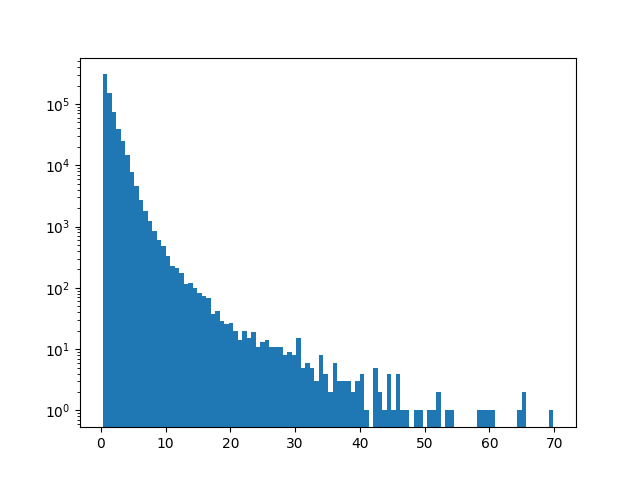

In [954]:
plt.figure()
plt.hist(scalings.detach().cpu().numpy(), bins=100)
plt.yscale('log')
plt.show()

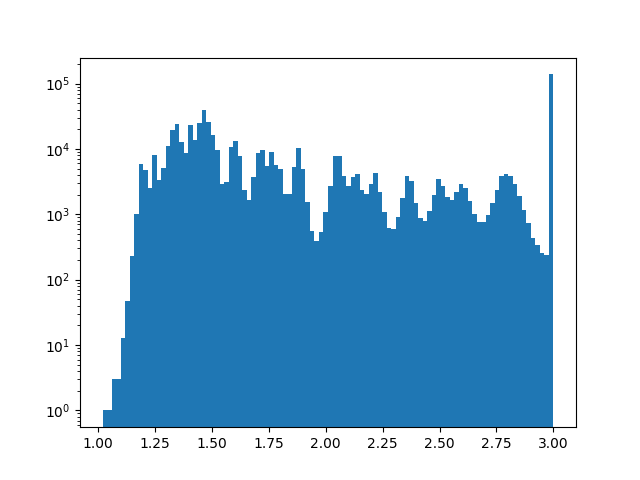

In [161]:
plt.figure()
plt.hist(scalings.detach().cpu().numpy(), bins=100)
plt.yscale('log')
plt.show()

In [791]:
viewpoint_stack = scene_opt.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

In [ ]:
gaussians_opt._scaling.data = torch.concat([torch.tensor(cluster1["_scaling"]).to(device=device)]* len(style_clusters), dim=0)

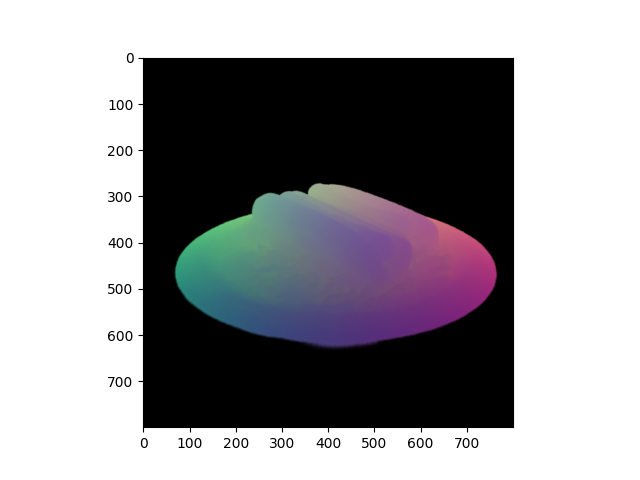

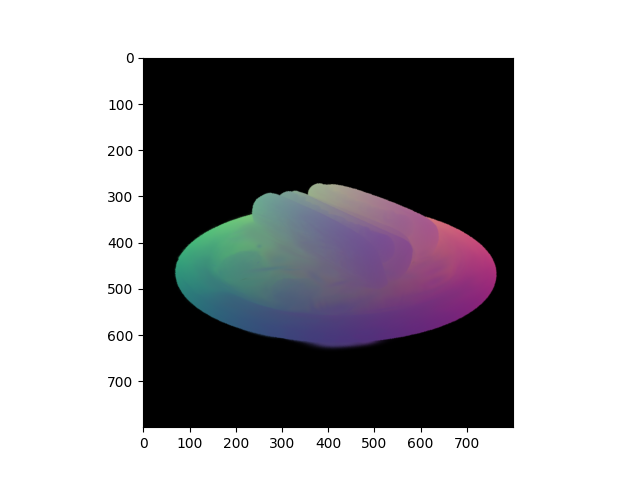

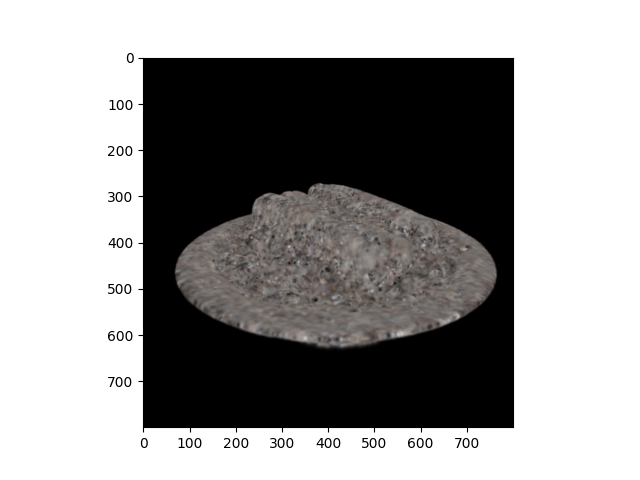

In [955]:
SCALING_FACTOR = 1.
# Sample camera

gaussians_opt._scaling.data /=  SCALING_FACTOR





# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()






gaussians_opt._features_dc.data = gaussians_opt_features_dc_original.clone()
gaussians_opt._features_rest.data = gaussians_opt_features_rest_original.clone()


# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


gaussians_opt._features_dc.data = gaussians_opt_features_dc_fitted.clone()
gaussians_opt._features_rest.data *= 0.

In [842]:

gaussians_opt._features_dc.data = gaussians_opt_features_dc_original.clone()
gaussians_opt._features_rest.data = gaussians_opt_features_rest_original.clone()*0.


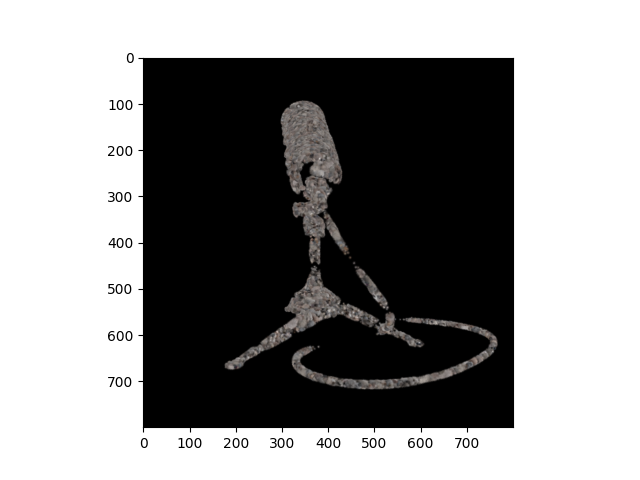

In [843]:
gaussians_opt._scaling.data = torch.concat([torch.tensor(cluster1["_scaling"]).to(device=device)]* len(style_clusters), dim=0)



# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()








In [844]:
with torch.no_grad():
    gaussians_opt._scaling.data = torch.concat([torch.tensor(cluster1["_scaling"]).to(device=device)]* len(style_clusters), dim=0)
    scalings_current = [get_descriptors(X=gaussians_opt._xyz.data[N_start:N_end], 
                                        X_nns_indices=nns_indices) for (N_start, N_end) in style_clusters_indcs]
    #scalings_current = [torch.clip(x, 0.2, 3.) for x in scalings_current]
    scalings = torch.concat([torch.mean(scaling_current,dim=-1) / (1e-8+torch.mean(target_descriptor_cluster,dim=-1))
                             for scaling_current in scalings_current], dim=0)
    scalings = torch.clip(scalings, 0.02, 3.)
    scalings = scalings.unsqueeze(1)
    gaussians_opt._scaling.data = torch.logit(torch.sigmoid(gaussians_opt._scaling.data) * scalings)

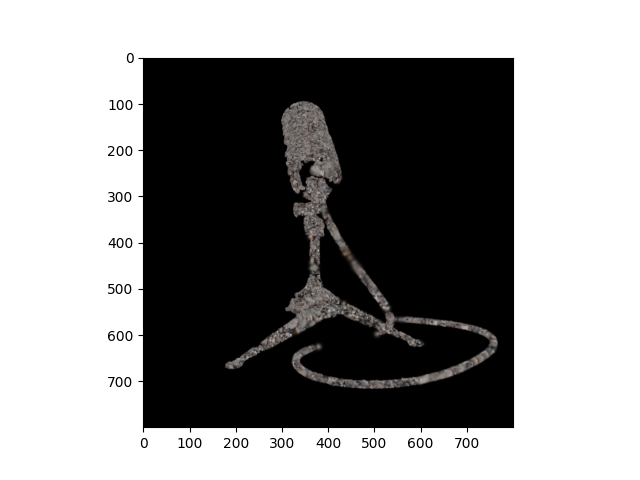

In [845]:


# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()



In [304]:
gaussians_opt._opacity.data = torch.concat([torch.tensor(x["_opacity"]).to(device=device) for x in style_clusters])


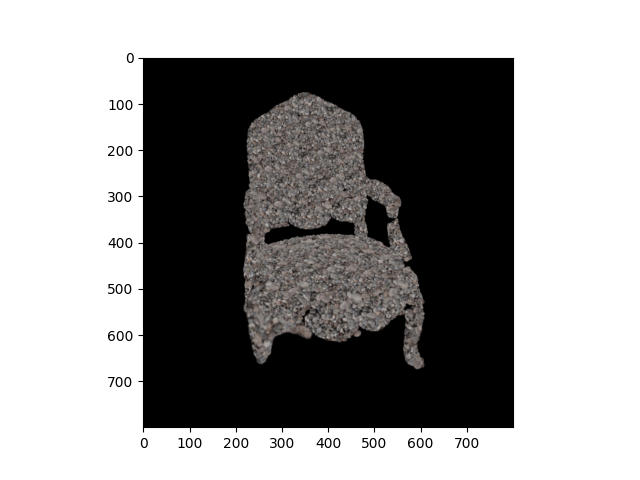

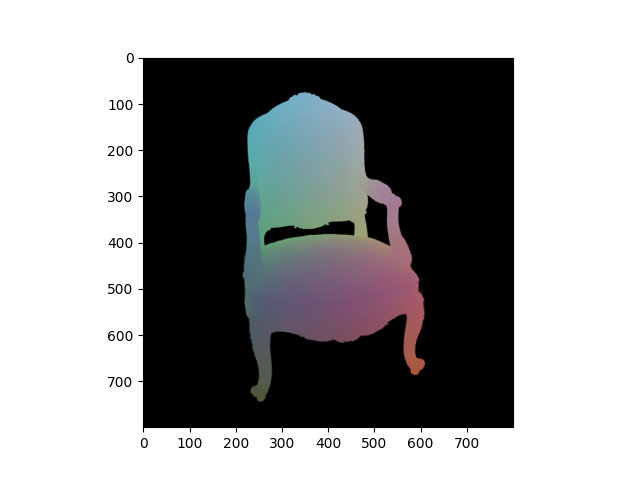

In [305]:
SCALING_FACTOR = 1.
# Sample camera

gaussians_opt._scaling.data /=  SCALING_FACTOR





# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()








In [284]:
gaussians_opt._features_dc.data = gaussians_opt_features_dc_fitted.clone()
gaussians_opt._features_rest.data *= 0.

In [947]:


gaussians_opt._features_dc.data = gaussians_opt_features_dc_original.clone()
gaussians_opt._features_rest.data = gaussians_opt_features_rest_original.clone()

import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './dummy_scene/' 
# MODEL_DIR_NEW = './fit_hotdog_with_rose_bush_lego_coast_rocks_fitted_with_masks_orig_scaling/'
MODEL_DIR_NEW = './fit_hotdog_pebbles_preselect_gaussians_larger_init_converged2/'
os.makedirs(MODEL_DIR_NEW, exist_ok = True)

! cp -r {MODEL_DIR}* {MODEL_DIR_NEW}
# ls MODEL_DIR


iteration=1
torch.save((gaussians_opt.capture(), iteration), MODEL_DIR_NEW + "/chkpnt" + str(iteration) + ".pth")
gaussians_opt.save_ply(os.path.join(MODEL_DIR_NEW, "point_cloud/iteration_1/", "point_cloud.ply"))

gaussians_opt._features_dc.data = gaussians_opt_features_dc_fitted.clone()
gaussians_opt._features_rest.data *= 0.


In [89]:
# Fix scalings.

In [ ]:
target_descriptor_cluster
scalings = torch.mean((descriptor_cluster_new / target_descriptor_cluster), dim=-1).unsqueeze(-1)
gaussians_opt._scaling.data = torch.logit(torch.sigmoid(gaussians_opt._scaling.data)*scalings)

In [ ]:
# Now just optimize color with a single SAM mask.

# Use perceptual loss

In [308]:
from utils.loss_utils import l1_loss, ssim, VGG, content_loss, style_loss, get_features, tv_loss
vgg = VGG().to("cuda").eval()




Model:
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18)

In [309]:
# image_feats = get_features(input_tensor=image, model=vgg)
# image_cont_feats = get_features(input_tensor=image_cont, model=vgg)
# on grayscale images


image_feats = get_features(input_tensor=image , model=vgg)
image_cont_feats = get_features(input_tensor=image_cont, model=vgg)

layers_content = [2,3] # was 2,3
loss_cont = content_loss([image_feats[i] for i in layers_content], [image_cont_feats[i] for i in layers_content])

In [314]:
image_feats[0].shape, image_feats[1].shape, image_feats[2].shape, image_feats[3].shape

(torch.Size([1, 64, 112, 112]),
 torch.Size([1, 128, 56, 56]),
 torch.Size([1, 256, 28, 28]),
 torch.Size([1, 512, 14, 14]),
 torch.Size([1, 512, 7, 7]))

In [337]:
gaussians_opt._opacity.data = torch.concat([torch.tensor(x["_opacity"]).to(device=device) for x in style_clusters])


In [590]:
losses_full=[]
losses_pixel = []
losses_reg = []
losses_tv = []
losses_loc_descr = []
losses_loc_descr_fine = []


gaussians_opt.training_setup(opt)
# for param_group in gaussians_opt.optimizer.param_groups:
#         param_group['lr'] = 1e-4


gaussians_opt._xyz.requires_grad = True
gaussians_opt._features_dc.requires_grad = True
gaussians_opt._features_rest.requires_grad = False
gaussians_opt._scaling.requires_grad = False
gaussians_opt._rotation.requires_grad = False
gaussians_opt._opacity.requires_grad = False
gaussians_opt.max_radii2D.requires_grad = False


In [624]:

for step in tqdm(range(5001)):
    gaussians_opt.optimizer.zero_grad()
    if True:
        # Pick a random Camera
        if not viewpoint_stack:
           viewpoint_stack = scene_opt.getTrainCameras().copy()
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
    # Optimization gaussians
    render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
    image, depth= render_pkg["render"], render_pkg["depth"]
    # Content gaussians
    render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
    image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


    loss_descriptor_local = \
        get_style_patch_descriptors_loss(
            clusters_to_opt_list=[gaussians_opt._xyz[N_start:N_end] / scaling 
                                  for ((N_start, N_end),scaling) in zip(style_clusters_indcs, style_clusters_scalings)],
            nns_indices=nns_indices,
            target_descriptor_cluster=target_descriptor_cluster,
            normalize=False)

        
    image_feats = get_features(input_tensor=image , model=vgg)
    image_cont_feats = get_features(input_tensor=image_cont, model=vgg)
    
    layers_content = [3,4] # was 1,2
    loss_cont = content_loss([image_feats[i] for i in layers_content], [image_cont_feats[i] for i in layers_content])
    loss_pixel = loss_cont #l1_loss(image, image_cont) 
    
    l_tv = tv_loss(image)
    l_reg = torch.mean(torch.square(gaussians_opt._xyz.unsqueeze(1) - gaussians_opt._features_dc))
    
    # loss = loss_pixel * 5e1  + l_tv * 0e-5 + l_reg * 1e1 + loss_descriptor_local * 1e7 #+ loss_descriptor_local_fine * 4e6 # was 1e4
    # loss = loss_pixel * 1e2  + l_tv * 0e-5 + l_reg * 1e3 + loss_descriptor_local * 1e4
    loss = loss_pixel * 1e2  + l_tv * 0e-5 + l_reg * 1e3 + loss_descriptor_local * 1e7
    loss.backward()

    gaussians_opt.optimizer.step()
    losses_full.append(float(loss.detach().cpu().numpy()))
    losses_pixel.append(float(loss_pixel.detach().cpu().numpy()))
    losses_reg.append(float(l_reg.detach().cpu().numpy()))
    losses_tv.append(float(l_tv.detach().cpu().numpy()))
    losses_loc_descr.append(float(loss_descriptor_local.detach().cpu().numpy()))
    

    with torch.no_grad():
        gaussians_opt._scaling.data = torch.concat([torch.tensor(cluster1["_scaling"]).to(device=device)]* len(style_clusters), dim=0)
        scalings_current = [get_descriptors(X=gaussians_opt._xyz.data[N_start:N_end], 
                                            X_nns_indices=nns_indices) for (N_start, N_end) in style_clusters_indcs]
        #scalings_current = [torch.clip(x, 0.2, 3.) for x in scalings_current]
        scalings = torch.concat([torch.mean(scaling_current,dim=-1) / (1e-8+torch.mean(target_descriptor_cluster,dim=-1))
                                 for scaling_current in scalings_current], dim=0)
        scalings = torch.clip(scalings, 0.02, 3.)
        scalings = scalings.unsqueeze(1)
        gaussians_opt._scaling.data = torch.logit(torch.sigmoid(gaussians_opt._scaling.data) * scalings)
    


    
    if step % 100 == 0:
        print(f"l_reg:{l_reg:.7f}",
              f"loss_descriptor_local:{loss_descriptor_local:.7f}",
              f"l_tv:{l_tv:.7f}, loss_pixel:{loss_pixel:.7f}, loss:{loss:.7f}")
    
  

/tmp/ipykernel_4168896/881826426.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(5001)):


  0%|          | 0/5001 [00:00<?, ?it/s]

l_reg:0.0171854 loss_descriptor_local:0.0052975 l_tv:0.0066317, loss_pixel:10.7246571, loss:54065.0546875
l_reg:0.0171759 loss_descriptor_local:0.0051489 l_tv:0.0041205, loss_pixel:8.9710007, loss:52402.8359375
l_reg:0.0171036 loss_descriptor_local:0.0050001 l_tv:0.0045865, loss_pixel:8.1917725, loss:50837.5078125
l_reg:0.0170040 loss_descriptor_local:0.0048504 l_tv:0.0037051, loss_pixel:7.9466276, loss:49315.9492188
l_reg:0.0168892 loss_descriptor_local:0.0047000 l_tv:0.0030467, loss_pixel:6.3689613, loss:47653.9375000
l_reg:0.0168087 loss_descriptor_local:0.0045491 l_tv:0.0038588, loss_pixel:6.6259065, loss:46170.6562500
l_reg:0.0167102 loss_descriptor_local:0.0043980 l_tv:0.0036848, loss_pixel:7.9571347, loss:44792.5390625
l_reg:0.0165957 loss_descriptor_local:0.0042469 l_tv:0.0040105, loss_pixel:6.4236088, loss:43128.2578125
l_reg:0.0165084 loss_descriptor_local:0.0040962 l_tv:0.0038089, loss_pixel:6.3432331, loss:41612.5039062
l_reg:0.0164101 loss_descriptor_local:0.0039460 l_tv:0

KeyboardInterrupt: 

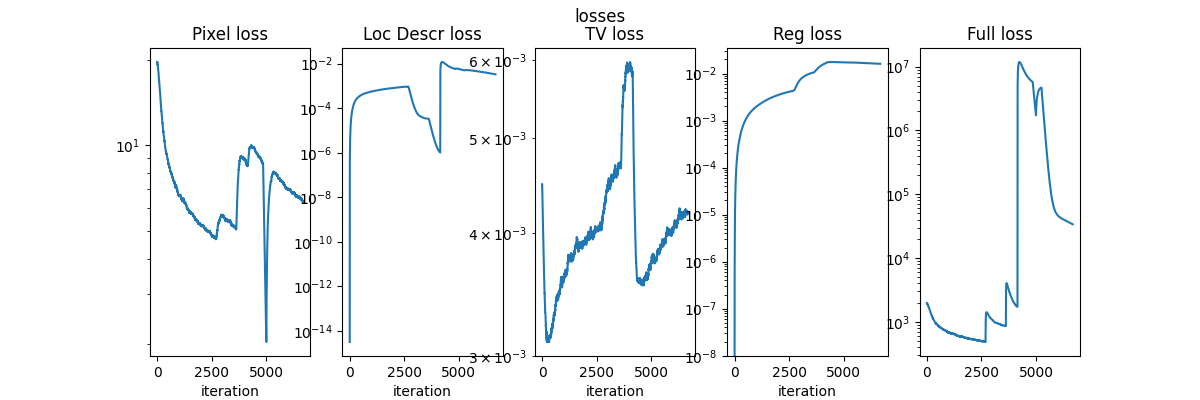

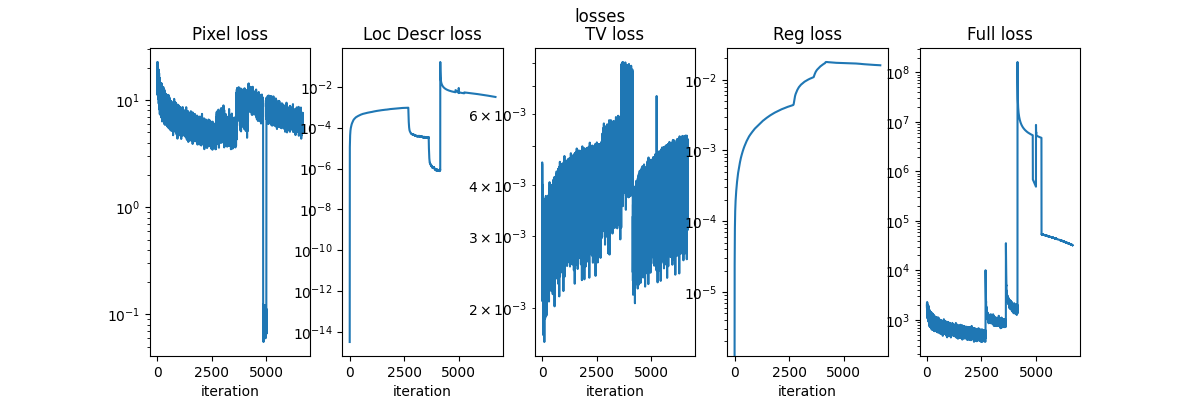

In [625]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
fig.suptitle("losses")
ax[0].set_title("Pixel loss")
ax[0].plot(calculate_ema(losses_pixel))
ax[0].set_yscale('log')
ax[1].set_title("Loc Descr loss")
ax[1].plot(calculate_ema(losses_loc_descr))
ax[1].set_yscale('log')

ax[2].set_title("TV loss")
ax[2].plot(calculate_ema(losses_tv))
ax[2].set_yscale('log')

# ax[2].set_title("Loc Descr fine loss")
# ax[2].plot(calculate_ema(losses_loc_descr_fine))
# ax[2].set_yscale('log')

ax[3].set_title("Reg loss")
ax[3].plot(calculate_ema(losses_reg))
ax[3].set_yscale('log')
ax[4].set_title("Full loss")
ax[4].plot(calculate_ema(losses_full))
ax[4].set_yscale('log')

for i in range(4): ax[i].set_xlabel("iteration")

plt.show()

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
fig.suptitle("losses")
ax[0].set_title("Pixel loss")
ax[0].plot(losses_pixel)
ax[0].set_yscale('log')
ax[1].set_title("Loc Descr loss")
ax[1].plot(losses_loc_descr)
ax[1].set_yscale('log')

ax[2].set_title("TV loss")
ax[2].plot(losses_tv)
ax[2].set_yscale('log')
ax[3].set_title("Reg loss")
ax[3].plot(losses_reg)
ax[3].set_yscale('log')
ax[4].set_title("Full loss")
ax[4].plot(losses_full)
ax[4].set_yscale('log')

for i in range(4): ax[i].set_xlabel("iteration")

plt.show()


In [626]:
gaussians_opt_features_dc_fitted = gaussians_opt._features_dc.data.detach().clone()

In [520]:
# gaussians_opt._scaling.data = torch.concat([torch.tensor(cluster1["_scaling"]).to(device=device)]* len(style_clusters), dim=0)

In [523]:
with torch.no_grad():
    gaussians_opt._scaling.data = torch.concat([torch.tensor(cluster1["_scaling"]).to(device=device)]* len(style_clusters), dim=0)
    scalings_current = [get_descriptors(X=gaussians_opt._xyz.data[N_start:N_end], 
                                        X_nns_indices=nns_indices) for (N_start, N_end) in style_clusters_indcs]
    #scalings_current = [torch.clip(x, 0.2, 3.) for x in scalings_current]
    scalings = torch.concat([torch.mean(scaling_current,dim=-1) / (1e-8+torch.mean(target_descriptor_cluster,dim=-1))
                             for scaling_current in scalings_current], dim=0)
    scalings = torch.clip(scalings, 0.2, 3.)
    scalings = scalings.unsqueeze(1)
    gaussians_opt._scaling.data = torch.logit(torch.sigmoid(gaussians_opt._scaling.data) * scalings)

In [627]:
scalings = torch.concat([torch.mean(scaling_current,dim=-1) / (1e-8+torch.mean(target_descriptor_cluster,dim=-1))
                             for scaling_current in scalings_current], dim=0)

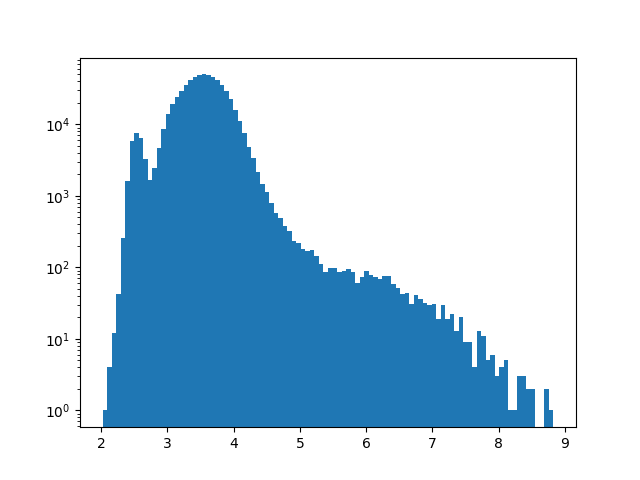

In [628]:
plt.figure()
plt.hist(scalings.detach().cpu().numpy(), bins=100)
plt.yscale('log')
plt.show()

In [611]:
viewpoint_stack = scene_opt.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


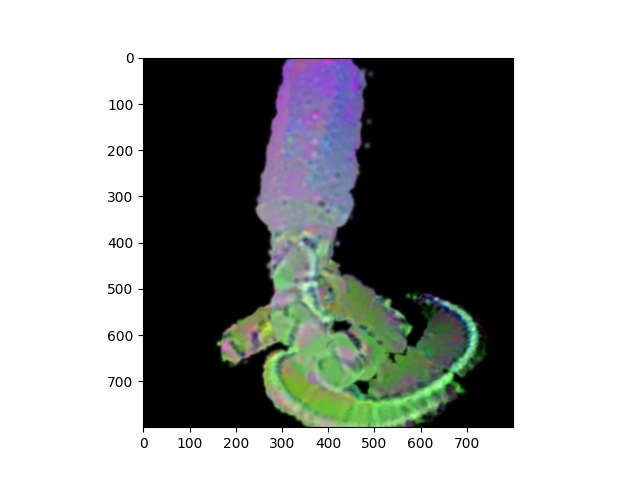

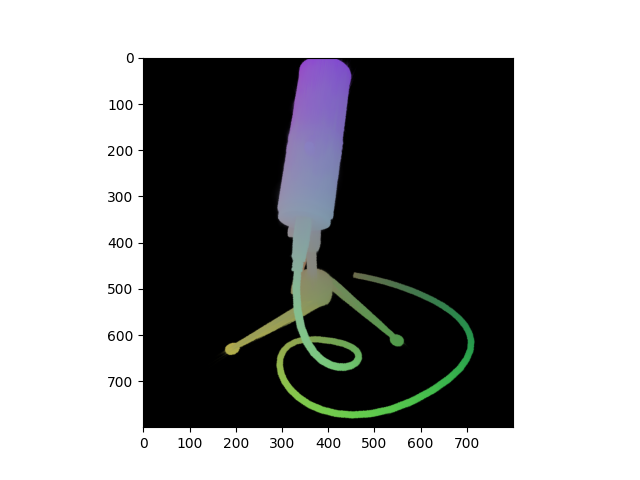

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


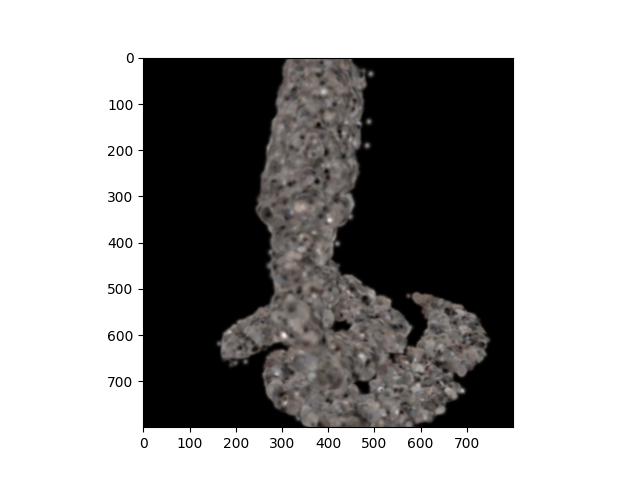

In [629]:
SCALING_FACTOR = 1.
# Sample camera

gaussians_opt._scaling.data /=  SCALING_FACTOR





# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()






gaussians_opt._features_dc.data = gaussians_opt_features_dc_original.clone()
gaussians_opt._features_rest.data = gaussians_opt_features_rest_original.clone()


# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


gaussians_opt._features_dc.data = gaussians_opt_features_dc_fitted.clone()
gaussians_opt._features_rest.data *= 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


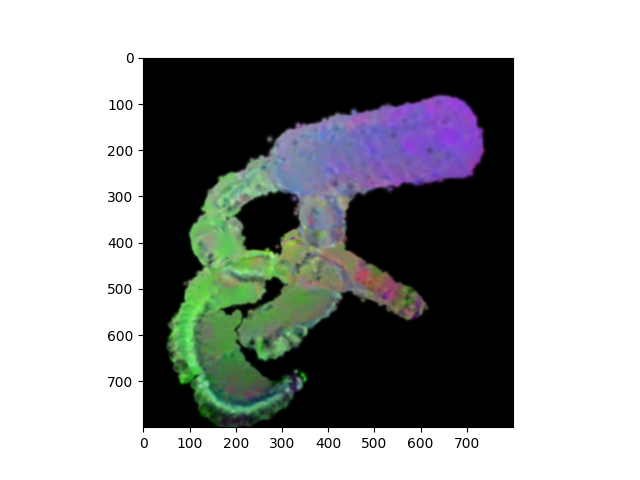

In [621]:
# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()

In [541]:
import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './dummy_scene/' 
# MODEL_DIR_NEW = './fit_hotdog_with_rose_bush_lego_coast_rocks_fitted_with_masks_orig_scaling/'
MODEL_DIR_NEW = './fit_chair_pebbles_adjust_scaling_percep_loss_converged5_with_normalization/'
os.makedirs(MODEL_DIR_NEW, exist_ok = True)

! cp -r {MODEL_DIR}* {MODEL_DIR_NEW}
# ls MODEL_DIR


iteration=1
torch.save((gaussians_opt.capture(), iteration), MODEL_DIR_NEW + "/chkpnt" + str(iteration) + ".pth")
gaussians_opt.save_ply(os.path.join(MODEL_DIR_NEW, "point_cloud/iteration_1/", "point_cloud.ply"))

